In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, sublevelset_heading_persistence
from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight

In [3]:
flights, data = flights_from_query(None, "./data/GA_dataset.pkl", load_results=True)

In [4]:
filtered_flight_data = [(f, d) for f, d in zip(flights, data) if large_gap_filter(f)]
flights, data = zip(*filtered_flight_data)  
flights = list(flights)
data = np.array(data)
simple = True

labels = data[:, 0]
if simple: 
    labels = (labels != 1).astype(int)

outside_data = data[:, 1:]

In [5]:
pers_objects = get_flight_persistances(flights, "flight_persistances", True)
LL_data, A_data, S_data, H_data = pers_objects

100%|██████████| 7910/7910 [00:34<00:00, 229.06it/s]


C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


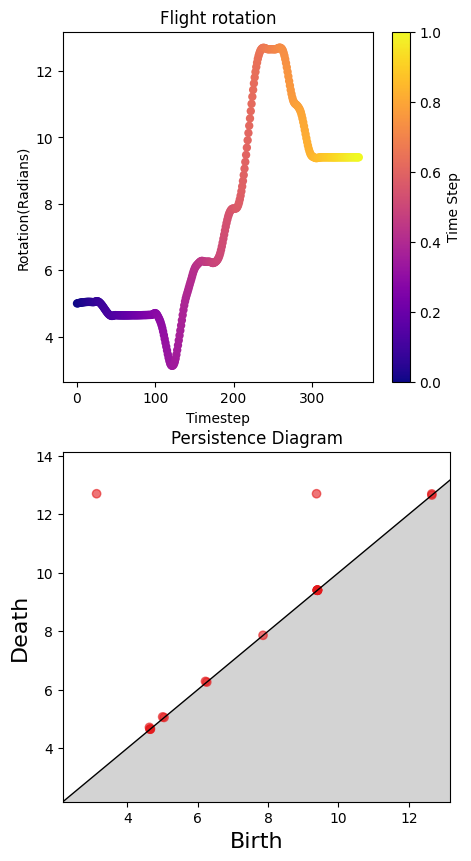

In [6]:
pers = pers_objects[3]
pers.plot_diagram(17)

In [7]:
from tqdm import tqdm
baseline = []

for flight in tqdm(flights, total=len(flights)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
    max_unwrapped = unwrapped.max()
    min_unwrapped = unwrapped.min()
    diff_unwrapped = max_unwrapped - min_unwrapped
    
    max_velocity = data["groundspeed"].max()
    min_velocity = data["groundspeed"].min()
    mean_velocity = data["groundspeed"].mean()
    max_heading = data["vertical_rate"].max()
    min_heading = data["vertical_rate"].min()
    mean_heading = data["vertical_rate"].mean()
    longitude_diff = data["longitude"].max() - data["longitude"].min()
    latitude_diff = data["latitude"].max() - data["latitude"].min()
    
    baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

baseline = np.array(baseline)

100%|██████████| 7910/7910 [00:04<00:00, 1865.65it/s]


In [8]:
seed = 42

B = [baseline, outside_data]
LL = [LL_data.stats]
A = [A_data.stats]
S = [S_data.stats]
H = [H_data.stats]

X = np.concatenate(B+LL+H, axis= 1)

mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]
Y = labels[mask]

indices = np.arange(len(X))

x_train, x_test_val, y_train, y_test_val, indices_train, indices_test_val = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)

#normalizer = preprocessing.Normalizer()
#x_train = normalizer.fit_transform(x_train)
#x_test_val = normalizer.transform(x_test_val)

x_test, x_val, y_test, y_val, indices_test, indices_val = train_test_split(x_test_val, y_test_val, indices_test_val, test_size=0.5, random_state=seed)

In [9]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

datalist = []
models = Models(seed).classifiers if simple else Models(seed).regressors

for i in models.keys():
    #does the gridsearch on the models
    model = GridSearchCV(models[i][0], models[i][1])
    #makes a prediction
    prediction = model.fit(x_train, y_train).predict(x_test)
    if simple:
        error =  balanced_accuracy_score(y_test, np.round(prediction))
    else:
        error = root_mean_squared_error(y_test, prediction)
    
    datalist.append([model.best_estimator_, error])

In [10]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

SVC(C=10, degree=2, random_state=42)                                  :  0.984
DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=30, max_iter=5000, random_state=42)  :  0.977
KNeighborsClassifier()                                                :  0.981
RandomForestClassifier(max_depth=6, n_estimators=300, random_state=42):  0.993
DecisionTreeClassifier(min_samples_leaf=2, random_state=42)           :  0.989


In [11]:
new_x_train =  np.concatenate((x_train, x_test), axis=0)
new_y_train = np.concatenate((y_train, y_test), axis=0)

if simple:
    best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]
    prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
    error =  balanced_accuracy_score(y_val, np.floor(prediction))
else:
    best_model = sorted(datalist, key=lambda x: x[1], reverse=False)[0][0]
    prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
    error = root_mean_squared_error(y_val, prediction)

error

0.9948528313819182

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, np.round(prediction))

array([[626,   3],
       [  3, 540]], dtype=int64)

#### B:          0.992
#### S:          0.948
#### H:          0.982
#### A:          0.949
#### LL:         0.943
#### S+H+A:      0.980
#### LL+S+H+A:   0.984
#### B+LL+S+H+A: 0.994
#### B+H:        0.995
#### B+LL+H      0.995
#### B+LL+S+H    0.996

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


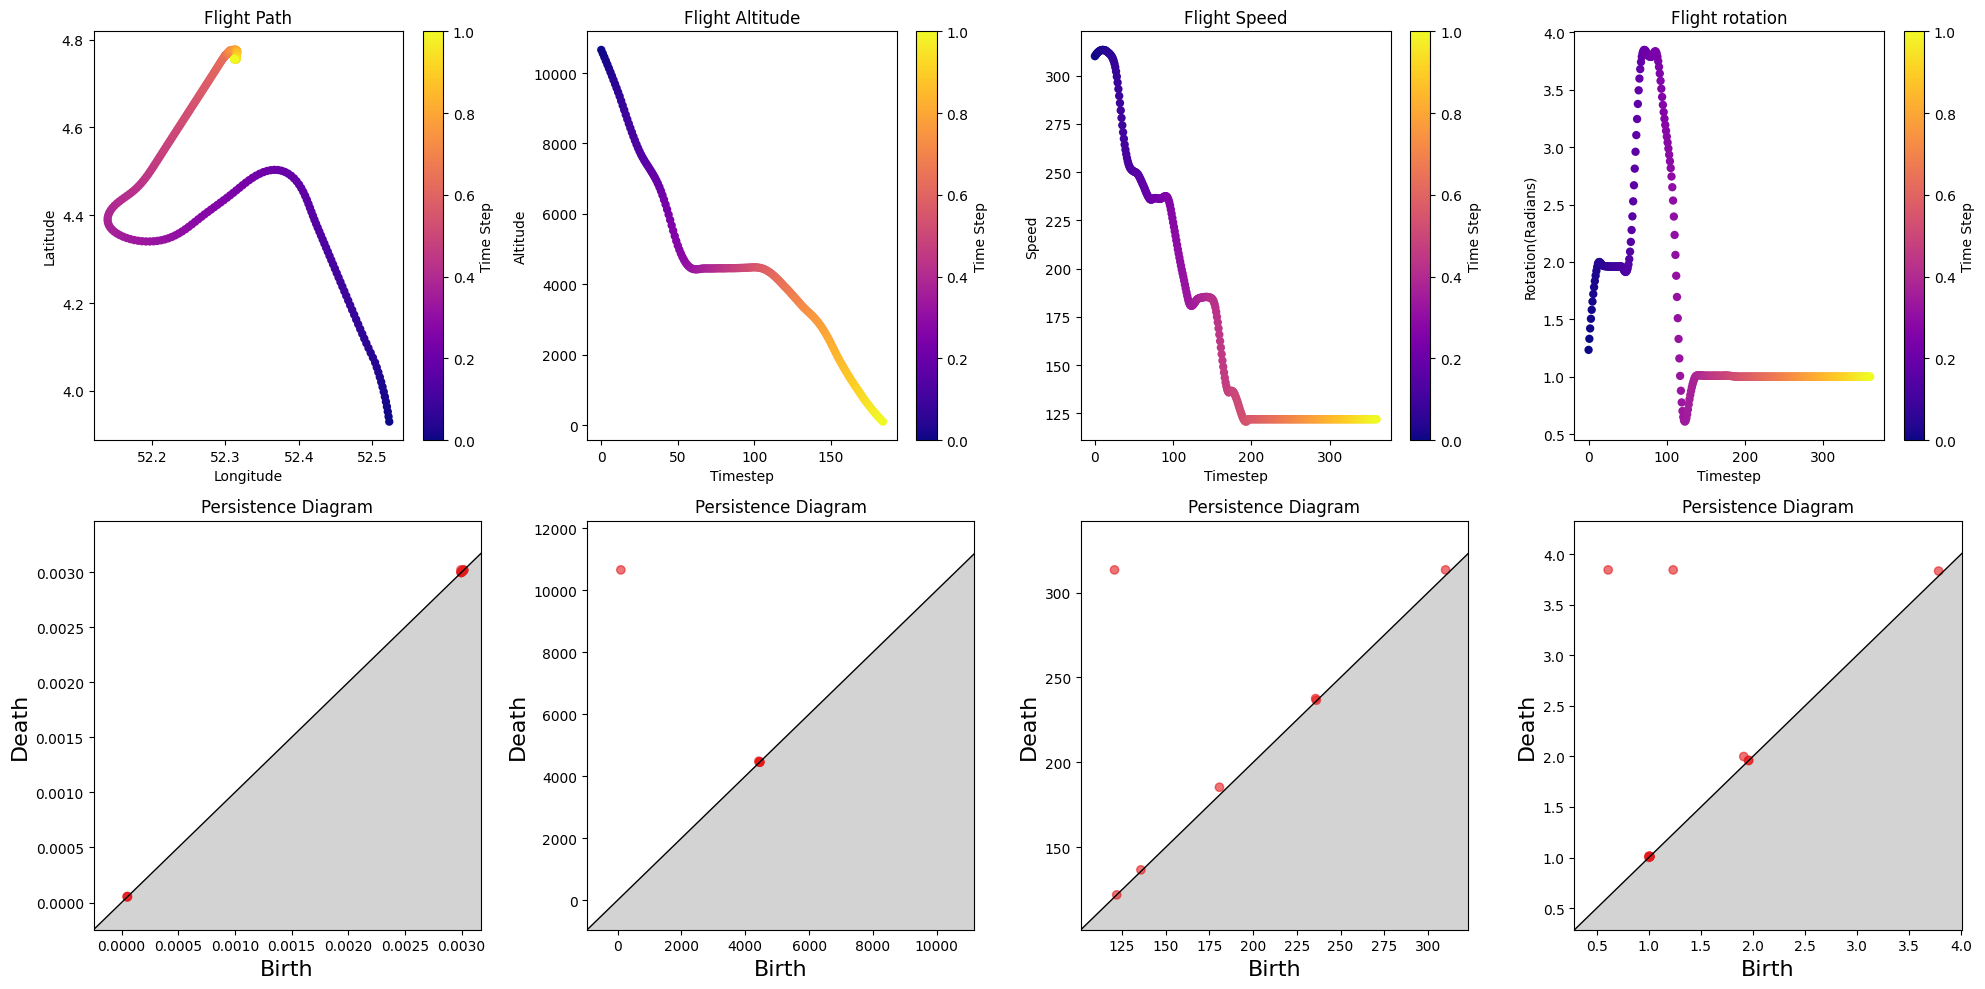

In [13]:
false_negatives = np.where(np.logical_and(y_val == 1, prediction == 0))[0]
false_positives = np.where(np.logical_and(y_val == 0, prediction == 1))[0]
positives = np.where(y_val == 1)[0]


index = 2
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)